<a href="https://colab.research.google.com/github/EternalSorrrow/bak/blob/master/ra2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MURA Pre-train

In [178]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
mura_path = 'drive/My Drive/Work/ML/MURA/MURA-v1.1/'

In [51]:
!ls 'drive/My Drive/Work/ML/MURA/MURA-v1.1' ; echo '' ; head -5 'drive/My Drive/Work/ML/MURA/MURA-v1.1/train_image_paths.csv' ; echo ''
!head -5 'drive/My Drive/Work/ML/MURA/MURA-v1.1/train_labeled_studies.csv'; echo '' ; head -5 'drive/My Drive/Work/ML/MURA/MURA-v1.1/valid_image_paths.csv'
!echo '' ; head -240 'drive/My Drive/Work/ML/MURA/MURA-v1.1/valid_labeled_studies.csv' | tail -6
#!find . -name \*.png | wc -l
!cat  'drive/My Drive/Work/ML/MURA/MURA-v1.1/train_image_paths.csv' | wc -l
!cat  'drive/My Drive/Work/ML/MURA/MURA-v1.1/valid_image_paths.csv' | wc -l

train		       train_labeled_studies.csv  valid_image_paths.csv
train_image_paths.csv  valid			  valid_labeled_studies.csv

MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png

MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1

MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png
MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png
MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png
MURA-v1.1/valid/XR_WRIST/patient11185/st

In [52]:
study_types = ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
study_type_codes = list(range(len(study_types)))
study_type_codes = dict(zip(study_types, study_type_codes))
study_type_codes

{'XR_ELBOW': 0,
 'XR_FINGER': 1,
 'XR_FOREARM': 2,
 'XR_HAND': 3,
 'XR_HUMERUS': 4,
 'XR_SHOULDER': 5,
 'XR_WRIST': 6}

In [53]:
import re

def encode_study_type(string):
  return study_type_codes[string]

def decode_study_type(num):
  for study_type, code in study_type_codes.items():
     if code == num:
       return study_type 

def extract_patient_id(string):
  return int(re.compile(r'patient(\d+)').findall(string)[0])

def extract_study_type(string):
  for study_type, code in study_type_codes.items():
    result = re.compile(study_type).findall(string)
    if result:
      return code

def extract_study_id(string):
  return int(re.compile(r'study(\d+)_').findall(string)[0])

def parse_study_desc(string):
  return (extract_study_type(string), extract_patient_id(string), extract_study_id(string))

def parse_label(string):
  return int(re.compile(r',(\d)').findall(string)[0])

with open(mura_path + 'valid_labeled_studies.csv', 'r') as f:
  line = f.readline()
  desc = parse_study_desc(line)
  print(line)
  print(desc)
  print(parse_label(line))
  print(decode_study_type(desc[0]))

MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/,1

(6, 11185, 1)
1
XR_WRIST


In [0]:
import pandas as pd
import os

def count_images(filename):
  counter = dict()
  
  with open(mura_path + filename, 'r') as file:
    lines = file.read().replace('MURA-v1.1/', '').split('\n')[:-1]
  
  for line in lines:
    desc = parse_study_desc(line)
    if desc not in counter.keys():
      counter[desc] = 1
    else:
      counter[desc] += 1
  
  return counter

def parse_study_metadata(filename, file_counts, verbose = False):
  metadata = pd.DataFrame(columns=['Category', 'Patient', 'Study', 'Images', 'Label'])

  with open(mura_path + filename, 'r') as file:
    lines = file.read().replace('MURA-v1.1/', '').split('\n')[:-1]
  
  linecount = len(lines)

  for i, line in enumerate(lines):
    category, patient, study = parse_study_desc(line)
    label = parse_label(line)
    line = line.split(',')[0]
    images = file_counts[(category, patient, study)]
    metadata.loc[i] = [category, patient, study, images, label]

    if (i + 1) % 1000 == 0:
      print('Read', i+1, 'items from', linecount)

  return metadata

In [55]:
train_metadata = parse_study_metadata('train_labeled_studies.csv', count_images('train_image_paths.csv'), True)
train_metadata.head()

Read 1000 items from 13457
Read 2000 items from 13457
Read 3000 items from 13457
Read 4000 items from 13457
Read 5000 items from 13457
Read 6000 items from 13457
Read 7000 items from 13457
Read 8000 items from 13457
Read 9000 items from 13457
Read 10000 items from 13457
Read 11000 items from 13457
Read 12000 items from 13457
Read 13000 items from 13457


,Category,Patient,Study,Images,Label
0,5,1,1,3,1
1,5,2,1,3,1
2,5,3,1,3,1
3,5,4,1,4,1
4,5,5,1,1,1


In [56]:
val_metadata = parse_study_metadata('valid_labeled_studies.csv', count_images('valid_image_paths.csv'), True)
val_metadata.head()

Read 1000 items from 1199


,Category,Patient,Study,Images,Label
0,6,11185,1,4,1
1,6,11186,1,2,1
2,6,11186,2,3,1
3,6,11186,3,3,1
4,6,11187,1,1,1


In [0]:
import matplotlib.pyplot as plt
import numpy as np

studies_train = train_metadata.groupby(by=['Category']).count()
studies_val = val_metadata.groupby(by=['Category']).count()

patients_train = train_metadata.groupby(by=['Category', 'Patient']).count().groupby(by=['Category']).count()
patients_val = val_metadata.groupby(by=['Category', 'Patient']).count().groupby(by=['Category']).count()

images_train = train_metadata.groupby(by=['Category'])['Images'].sum()
images_val = val_metadata.groupby(by=['Category'])['Images'].sum()

labels_studies_train = train_metadata.groupby(by=['Label']).count()
labels_images_train = train_metadata.groupby(by=['Label'])['Images'].sum()

labels_studies_val = val_metadata.groupby(by=['Label']).count()
labels_images_val = val_metadata.groupby(by=['Label'])['Images'].sum()

train_labels_per_study = dict()
val_labels_per_study = dict()

train_labels_per_study_imgs = dict()
val_labels_per_study_imgs = dict()

for _, study_code in study_type_codes.items():
  tr = train_metadata.loc[train_metadata['Category'] == study_code].groupby(by=['Label'])['Study'].count()
  vl = val_metadata.loc[val_metadata['Category'] == study_code].groupby(by=['Label'])['Study'].count()

  tr_im = train_metadata.loc[train_metadata['Category'] == study_code].groupby(by=['Label'])['Images'].sum()
  vl_im = val_metadata.loc[val_metadata['Category'] == study_code].groupby(by=['Label'])['Images'].sum()
  
  train_labels_per_study[study_code] = tr
  val_labels_per_study[study_code] = vl

  train_labels_per_study_imgs[study_code] = tr_im
  val_labels_per_study_imgs[study_code] = vl_im

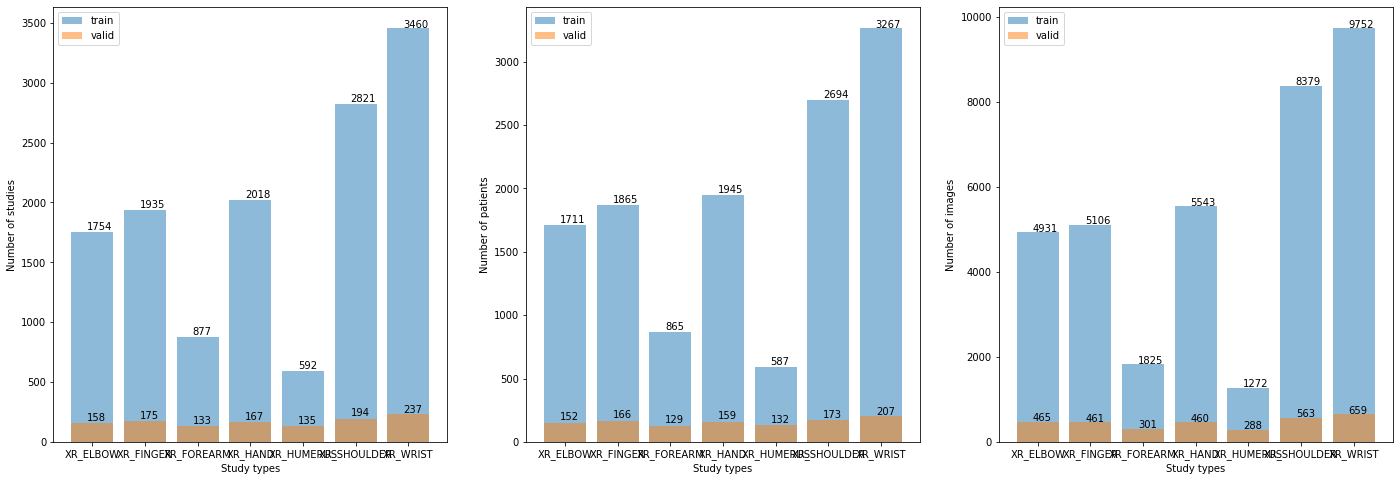

In [58]:
fig, ax = plt.subplots(figsize=(24, 8), ncols=3)

for i, phase in enumerate([studies_train, studies_val]):
    counts = phase[['Study']].values.ravel()
    m = max(counts)
    for i, v in enumerate(counts):
      if v==m: ax[0].text(i-0.1, v+3, str(v))
      else: ax[0].text(i-0.1, v + 20, str(v))
    x_pos = np.arange(len(study_types))
    ax[0].bar(x_pos, counts, alpha=0.5)
    ax[0].set_xticks(x_pos)
    ax[0].set_xticklabels(study_types)

for i, phase in enumerate([patients_train, patients_val]):
    counts = phase[['Study']].values.ravel()
    m = max(counts)
    for i, v in enumerate(counts):
      if v==m: ax[1].text(i-0.1, v+3, str(v))
      else: ax[1].text(i-0.1, v + 20, str(v))
    x_pos = np.arange(len(study_types))
    ax[1].bar(x_pos, counts, alpha=0.5)
    ax[1].set_xticks(x_pos)
    ax[1].set_xticklabels(study_types)

for i, phase in enumerate([images_train, images_val]):
    counts = phase.values.ravel()
    m = max(counts)
    for i, v in enumerate(counts):
      if v==m: ax[2].text(i-0.1, v+3, str(v))
      else: ax[2].text(i-0.1, v + 20, str(v))
    x_pos = np.arange(len(study_types))
    ax[2].bar(x_pos, counts, alpha=0.5)
    ax[2].set_xticks(x_pos)
    ax[2].set_xticklabels(study_types)

ax[0].set_xlabel('Study types')
ax[0].set_ylabel('Number of studies')
ax[0].legend(['train', 'valid'])

ax[1].set_xlabel('Study types')
ax[1].set_ylabel('Number of patients')
ax[1].legend(['train', 'valid'])

ax[2].set_xlabel('Study types')
ax[2].set_ylabel('Number of images')
ax[2].legend(['train', 'valid'])

plt.show()

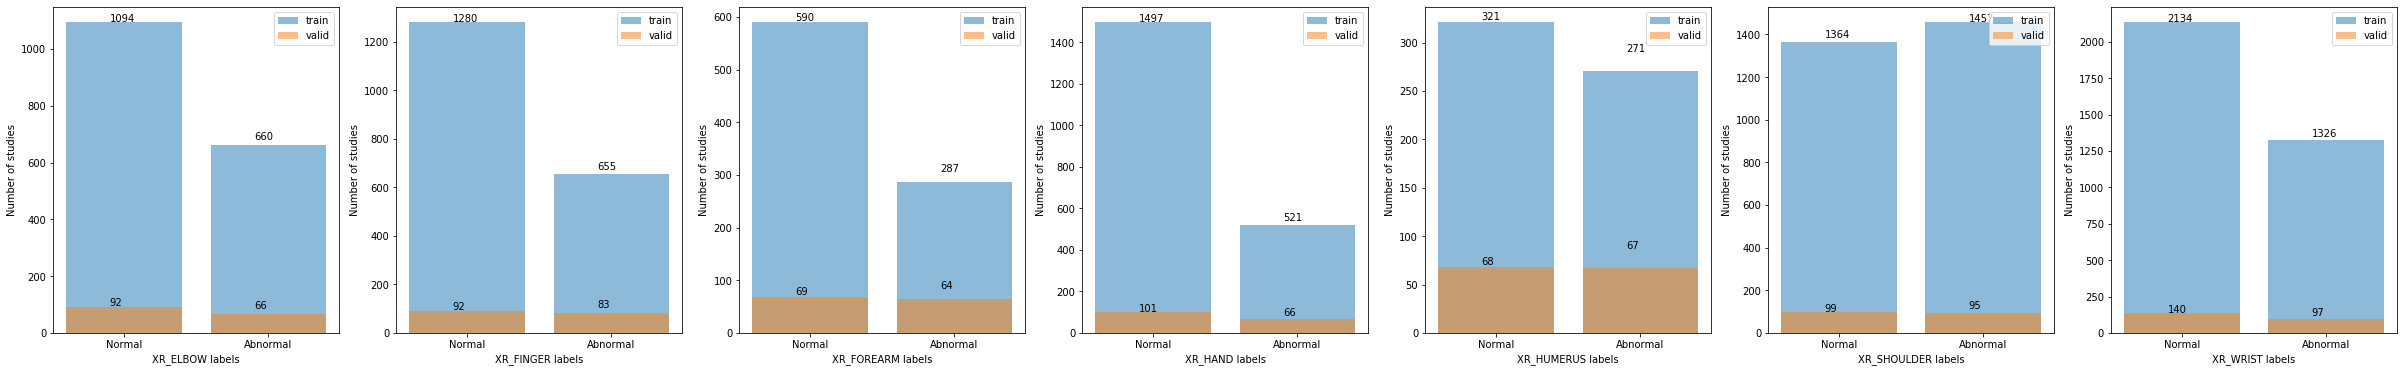

In [59]:
fig, ax = plt.subplots(figsize=(6 * len(study_types), 6), ncols=len(study_types))
label_values = ['Normal', 'Abnormal']

for y in range(len(study_types)):
    for i, phase in enumerate([train_labels_per_study[y], val_labels_per_study[y]]):
      counts = phase.values.ravel()
      m = max(counts)
      for i, v in enumerate(counts):
        if v==m: ax[y].text(i-0.1, v+3, str(v))
        else: ax[y].text(i-0.1, v + 20, str(v))
      x_pos = np.arange(2)

      ax[y].bar(x_pos, counts, alpha=0.5)
      ax[y].set_xticks(x_pos)
      ax[y].set_xticklabels(label_values)

      ax[y].set_xlabel(study_types[y] + ' labels')
      ax[y].set_ylabel('Number of studies')
      ax[y].legend(['train', 'valid'])


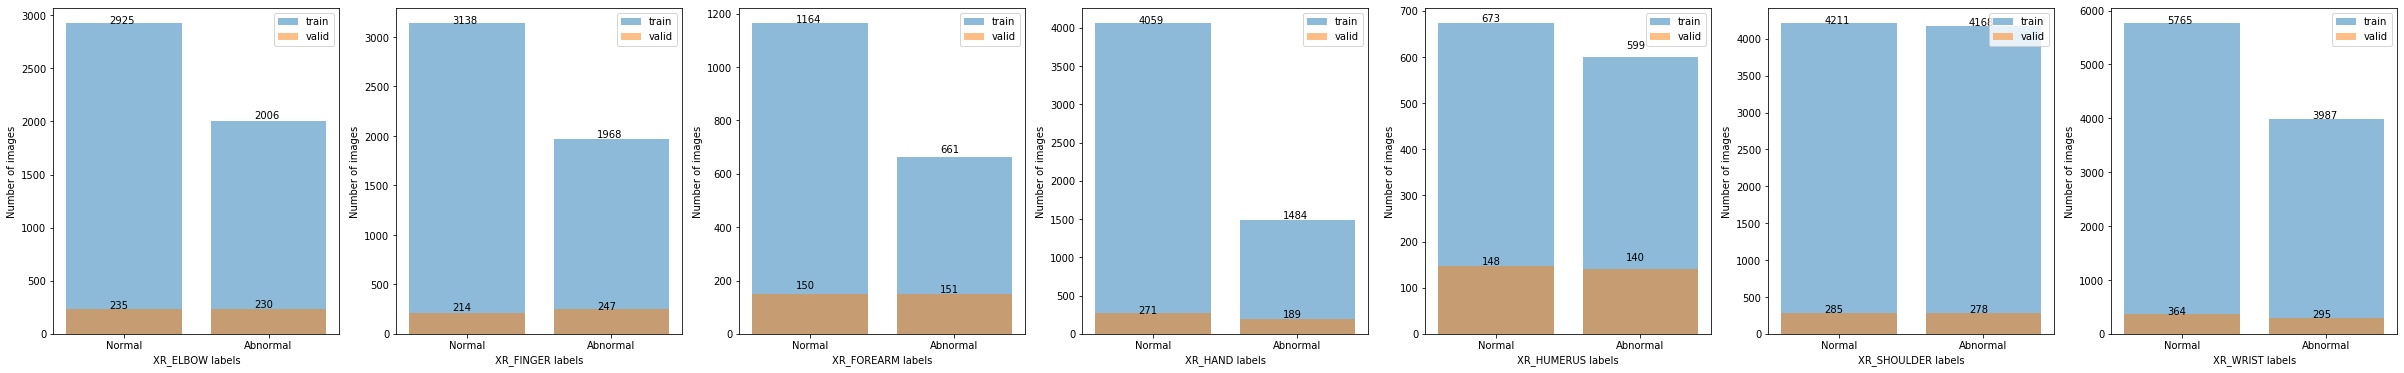

In [60]:
fig, ax = plt.subplots(figsize=(6 * len(study_types), 6), ncols=len(study_types))
label_values = ['Normal', 'Abnormal']

for y in range(len(study_types)):
    for i, phase in enumerate([train_labels_per_study_imgs[y], val_labels_per_study_imgs[y]]):
      counts = phase.values.ravel()
      m = max(counts)
      for i, v in enumerate(counts):
        if v==m: ax[y].text(i-0.1, v+3, str(v))
        else: ax[y].text(i-0.1, v + 20, str(v))
      x_pos = np.arange(2)

      ax[y].bar(x_pos, counts, alpha=0.5)
      ax[y].set_xticks(x_pos)
      ax[y].set_xticklabels(label_values)

      ax[y].set_xlabel(study_types[y] + ' labels')
      ax[y].set_ylabel('Number of images')
      ax[y].legend(['train', 'valid'])


In [0]:
input_size = (320, 320)
n_classes = 2

In [62]:
train_paths, val_paths = [], []

with open(mura_path + 'train_image_paths.csv', 'r') as file:
  train_paths = file.read().replace('MURA-v1.1/', '').split('\n')[:-1]

with open(mura_path + 'valid_image_paths.csv', 'r') as file:
  val_paths = file.read().replace('MURA-v1.1/', '').split('\n')[:-1]

print(len(train_paths), len(val_paths))

36808 3197


In [63]:
def separate_paths(paths):  
  sep_paths = dict()
  for study_type in study_types:
    sep_paths[study_type] = []

  for path in paths:
    for study_type in study_types:
      if study_type in path:
        sep_paths[study_type].append(path)

  return sep_paths

train_paths = separate_paths(train_paths)
val_paths = separate_paths(val_paths)

print([len(array) for key, array in train_paths.items()])
print([len(array) for key, array in val_paths.items()])

[4931, 5106, 1825, 5543, 1272, 8379, 9752]
[465, 461, 301, 460, 288, 563, 659]


In [71]:
train_label_paths, val_label_paths = [], []

with open(mura_path + 'train_labeled_studies.csv', 'r') as file:
  train_label_paths = file.read().split('\n')[:-1]

with open(mura_path + 'valid_labeled_studies.csv', 'r') as file:
  val_label_paths = file.read().split('\n')[:-1]

train_label_paths = separate_paths(train_label_paths)
val_label_paths = separate_paths(val_label_paths)

print([len(array) for key, array in train_label_paths.items()])
print([len(array) for key, array in val_label_paths.items()])

[1754, 1935, 877, 2018, 592, 2821, 3460]
[158, 175, 133, 167, 135, 194, 237]


In [87]:
def extract_labels(paths):
  return list(map(parse_label, paths))

def extract_descs(paths):
  return list(map(parse_study_desc, paths))

def get_labels_dict(path_dict):
  labels_dict = dict()
  for study_type in study_types:
    labels_dict[study_type] = dict()

  for study_type, paths in path_dict.items():
    labels_dict[study_type] = dict(list(zip(extract_descs(paths), extract_labels(paths))))
  return labels_dict

train_labels = get_labels_dict(train_label_paths)
val_labels = get_labels_dict(val_label_paths)

print([len(array) for key, array in train_labels.items()])
print([len(array) for key, array in val_labels.items()])

[1754, 1935, 877, 2018, 592, 2821, 3460]
[158, 175, 133, 167, 135, 194, 237]


In [0]:
import cv2

def read_images(paths, image_size=input_size, mono=False, verb_step = 200, read_first=-1):
  interpolation = cv2.INTER_AREA
  imgs = []

  print('Starting reading...')
  if read_first > 0:
    paths = paths[:read_first]

  for i, path in enumerate(paths):
    img = cv2.imread(mura_path + path)
    if img is None:
      print('None image on path:', mura_path + path)
    
    else:
      if mono:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img = cv2.resize(img, dsize=image_size, interpolation=interpolation)
      desc = parse_study_desc(path)
      imgs.append((desc, img))
    
    if (i + 1) % verb_step == 0:
      print('Read', i, 'images from', len(paths))
  
  return imgs


In [0]:
def read_category_data(category, read_first=-1):
  train_raw = read_images(train_paths[category], read_first=read_first)
  valid_raw = read_images(val_paths[category], read_first=read_first)

  t_imgs = np.array(list(map(lambda x: x[1], train_raw)))
  t_labels = np.array(list(map(lambda x: train_labels[category][x[0]], train_raw)))

  v_imgs = np.array(list(map(lambda x: x[1], valid_raw)))
  v_labels = np.array(list(map(lambda x: val_labels[category][x[0]], valid_raw)))

  return t_imgs, t_labels, v_imgs, v_labels

In [0]:
import numpy as np
import h5py

export_folder = 'drive/My Drive/Work/ML/RA2/'

def export_to_hdf5(train_data, train_labels, valid_data, valid_labels, output_filename, data_order='tf'):
  #data_order = 'th' for Theano, 'tf' for Tensorflow
  # check the order of data and chose proper data shape to save images

  if data_order == 'th':
      train_shape = (train_data.shape[0], train_data.shape[3], train_data.shape[1], train_data.shape[2])
      val_shape = (valid_data.shape[0], valid_data.shape[3], valid_data.shape[1], valid_data.shape[2])
  elif data_order == 'tf':
      train_shape = (train_data.shape)
      val_shape = (valid_data.shape)

  # open a hdf5 file and create earrays
  with h5py.File(output_filename+'.hdf5', mode='w') as hdf5_file:
    
    hdf5_file.create_dataset("train_img", train_shape, np.uint8)
    hdf5_file.create_dataset("val_img", val_shape, np.uint8)
    hdf5_file.create_dataset("train_labels", (len(train_labels),), np.int8)
    hdf5_file.create_dataset("val_labels", (len(valid_labels),), np.int8)


    hdf5_file["train_labels"][...] = train_labels
    hdf5_file["val_labels"][...] = valid_labels

    for i in range(len(train_data)):
        if i % 200 == 0 and i > 1:
            print('Train data: {}/{}'.format(i, len(train_data)))
        img = train_data[i]
        
        # if the data order is Theano, axis orders should change
        if data_order == 'th':
            img = np.rollaxis(img, 2)
        # save the image and calculate the mean so far
        hdf5_file["train_img"][i, :, :, :] = img
        
    for i in range(len(valid_data)):
        # print how many images are saved every 1000 images
        if i % 200 == 0 and i > 1:
            print('Validation data: {}/{}'.format(i, len(valid_data)))
        img = valid_data[i]
        
        # if the data order is Theano, axis orders should change
        if data_order == 'th':
            img = np.rollaxis(img, 2)
        # save the image
        hdf5_file["val_img"][i, :, :, :] = img
    

In [0]:
def import_from_hdf5(path):
  with h5py.File(path, "r", driver='core') as hdf5_file:

    train_data = None
    batch_begin, batch_end = 0, 200
    train_samples = len(hdf5_file['train_img'])
    while True:
      batch_end = min(batch_end, train_samples)
      batch = hdf5_file['train_img'][batch_begin:batch_end, :, :, :]
      if train_data is None:
        train_data = batch
      else:
        train_data = np.concatenate([train_data, batch], axis=0)
      print('Loaded', batch_end, 'samples of', train_samples, 'samples of train data')
      if batch_end == train_samples:
        break
      else:
        batch_begin = batch_end
        batch_end += 200

    train_labels = hdf5_file['train_labels'][:]
    
    valid_data = None
    batch_begin, batch_end = 0, 200
    val_samples = len(hdf5_file['val_img'])
    while True:
      batch_end = min(batch_end, val_samples)
      batch = hdf5_file['val_img'][batch_begin:batch_end, :, :, :]
      if valid_data is None:
        valid_data = batch
      else:
        valid_data = np.concatenate([valid_data, batch], axis=0)
      print('Loaded', batch_end, 'samples of', val_samples, 'samples of val data')
      if batch_end == val_samples:
        break
      else:
        batch_begin = batch_end
        batch_end += 200
    
    valid_labels = hdf5_file['val_labels'][:]

    train_data, valid_data = train_data[:, :, :, :], valid_data[:, :, :, :]
    
  return train_data, train_labels, valid_data, valid_labels

In [196]:
hand_train, hand_train_labels, hand_valid, hand_valid_labels = read_category_data('XR_HAND')

Starting reading...
Read 199 images from 5543
Read 399 images from 5543
Read 599 images from 5543
Read 799 images from 5543
Read 999 images from 5543
Read 1199 images from 5543
Read 1399 images from 5543
Read 1599 images from 5543
Read 1799 images from 5543
Read 1999 images from 5543
Read 2199 images from 5543
Read 2399 images from 5543
Read 2599 images from 5543
Read 2799 images from 5543
Read 2999 images from 5543
Read 3199 images from 5543
Read 3399 images from 5543
Read 3599 images from 5543
Read 3799 images from 5543
Read 3999 images from 5543
Read 4199 images from 5543
Read 4399 images from 5543
Read 4599 images from 5543
Read 4799 images from 5543
Read 4999 images from 5543
Read 5199 images from 5543
Read 5399 images from 5543
Starting reading...
Read 199 images from 460
Read 399 images from 460


In [198]:
print(hand_train.shape, hand_train_labels.shape, hand_valid.shape, hand_valid_labels.shape)

export_to_hdf5(hand_train, hand_train_labels, hand_valid, hand_valid_labels, export_folder + 'hand')

(5543, 320, 320, 3) (5543,) (460, 320, 320, 3) (460,)
Train data: 200/5543
Train data: 400/5543
Train data: 600/5543
Train data: 800/5543
Train data: 1000/5543
Train data: 1200/5543
Train data: 1400/5543
Train data: 1600/5543
Train data: 1800/5543
Train data: 2000/5543
Train data: 2200/5543
Train data: 2400/5543
Train data: 2600/5543
Train data: 2800/5543
Train data: 3000/5543
Train data: 3200/5543
Train data: 3400/5543
Train data: 3600/5543
Train data: 3800/5543
Train data: 4000/5543
Train data: 4200/5543
Train data: 4400/5543
Train data: 4600/5543
Train data: 4800/5543
Train data: 5000/5543
Train data: 5200/5543
Train data: 5400/5543
Validation data: 200/460
Validation data: 400/460


In [0]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense
from keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from keras.optimizers import adam

label_smoothing = 0.0

learning_rate = 0.0001
beta1=0.9
beta2=0.999

def loss(y_true, y_pred): #Wrapping a tf loss to the keras interface with only 2 args
  return binary_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)

optimizer = adam(lr=learning_rate, beta_1=beta1, beta_2=beta2)

def get_compiled_model_instance():
  base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=None, pooling='avg')

  x = base_model.output
  predictions = Dense(n_classes, activation='sigmoid')(x)

  model = Model(inputs=base_model.input, outputs=predictions)
  model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

  return model

#get_compiled_model_instance()

In [0]:
hand_model = get_compiled_model_instance()

In [0]:
#@title
!ls 'drive/My Drive/Work/ML/RA2/ra2'

In [0]:
#@title
import pandas as pd 

data = pd.read_csv('drive/My Drive/Work/ML/RA2/ra2/Subset_training.csv')
data.head()

In [0]:
#@title
import os
import cv2

ra2_path = 'drive/My Drive/Work/ML/RA2/ra2/'
imgs = []

files = sorted(os.listdir(ra2_path + 'Subset_Training'))
print(files)

for file in files:
  imgs.append((file, cv2.imread(ra2_path + 'Subset_Training/' + file)))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.imshow(imgs[0][1], cmap = plt.cm.gray)

In [0]:
#@title
import numpy as np

img = imgs[0][1]

#Sum of the cross-differences between all 3 pairs of channels to determine, can we use a grayscale image without substantional information loss
diff_map = np.abs(img[:,:,0]-img[:, :, 1])+np.abs(img[:,:,0]-img[:, :, 2]) + np.abs(img[:,:,1]-img[:,:,2])

print(np.mean(diff_map), np.var(diff_map))#All 3 channels are the same, we can reduce the input tensor size 3x by using the grayscale image